<a href="https://colab.research.google.com/github/yebiny/SkillTreePython-DeepLearning/blob/main/01.%EB%94%A5%EB%9F%AC%EB%8B%9Dwith%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0-basic/%ED%95%B4%EC%84%A4/ch01_05_DNN%EA%B8%B0%EC%B4%88_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch01.05. 딥러닝 다중 분류 모델
---
* 날짜:
* 이름:

## 학습내용
    - 딥러닝을 이용한 멀티클래스 분류 진행
    - 적절한 손실함수와 최적화 함수 정의
    - 평가 및 예측
    
## 학습자료

* 모두의딥러닝
* 데이터
  * `iris.csv`
  * MNIST 데이터셋


```
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
seed=1
np.random.seed(seed)
tf.random.set_seed(seed)
```

```
https://github.com/yebiny/SkillTreePython-DeepLearning.git
```

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
seed=1
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
! git clone https://github.com/yebiny/SkillTreePython-DeepLearning.git

Cloning into 'SkillTreePython-DeepLearning'...
remote: Enumerating objects: 359, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 359 (delta 112), reused 120 (delta 78), pack-reused 178
Receiving objects: 100% (359/359), 22.36 MiB | 19.72 MiB/s, done.
Resolving deltas: 100% (147/147), done.


## 아이리스 꽃 종류 예측
---


```
- 0 sepal_length  꽃받침 길이
- 1 sepal_width 꽃받침 너비
- 2 petal_length 꽃임 길이
- 3 petal_width 꽃잎 너비
- 4 species 꽃의 종류 {setosa, versicolor virginica}
```
<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-01.PNG?raw=true width=550>
</p>


In [4]:
data_path = '/content/SkillTreePython-DeepLearning/dataset/iris.csv'
df = pd.read_csv(data_path, header=None)
df

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


Text(0.5, 1.0, 'all dataset')

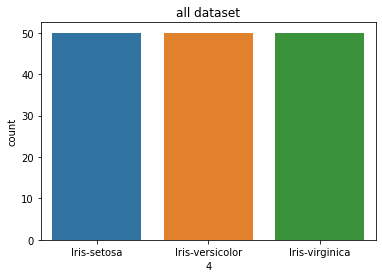

In [6]:
sns.countplot(x=df[4]);plt.title('all dataset')

In [8]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

def iris_preprocess(df, seed=1):
  # x-y 분할
  x = df.values[:, :-1] #(전체샘플, 마지막 변수 전까지)
  y = df.values[:, -1] # (전체샘플, 마지막 변수)
  # 정규화 (x 데이터만)
  ss = StandardScaler()
  x = ss.fit_transform(x)
  # 원-핫 (y 데이터만)
  oh = OneHotEncoder(sparse=False)
  y = oh.fit_transform(np.expand_dims(y, 1)) # 인풋이 무조건 행렬 (150, ) -> (150, 1)
  print(f'원-핫 변환 순서: {oh.categories_}')
  # train-test 분할
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,
                                                      random_state=seed,
                                                      stratify = y)
  return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = iris_preprocess(df)
print(f'데이터 형태: {x_train.shape}, {x_test.shape}, {y_train.shape}, {y_test.shape}')
print(f'첫번째 샘플 x:{x_train[0]} y:{y_train[0]}')

원-핫 변환 순서: [array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)]
데이터 형태: (105, 4), (45, 4), (105, 3), (45, 3)
첫번째 샘플 x:[ 0.55333328 -0.58776353  0.76275864  0.39617188] y:[0. 0. 1.]


* 예측값 분포 확인

Text(0.5, 1.0, 'test dataset')

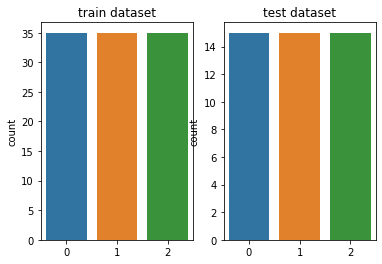

In [10]:
plt.subplot(121);sns.countplot(x=np.argmax(y_train, axis=1));plt.title('train dataset')
plt.subplot(122);sns.countplot(x=np.argmax(y_test, axis=1));plt.title('test dataset')

### | 모델


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-02.PNG?raw=true width=800>
</p>


#### **모델 생성**

In [21]:
from tensorflow.keras import models, layers, utils

def build_model():
  x = layers.Input(shape=(4,))
  y = layers.Dense(12, activation='relu')(x)
  y = layers.Dense(8, activation='relu')(y)
  y = layers.Dense(3, activation='softmax', name='OutputLayer')(y)
  model = models.Model(x, y)
  return model

#### **모델 시각화**

* `model.summary()`
* `utils.plot_model()`

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_4 (Dense)             (None, 12)                60        
                                                                 
 dense_5 (Dense)             (None, 8)                 104       
                                                                 
 OutputLayer (Dense)         (None, 3)                 27        
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


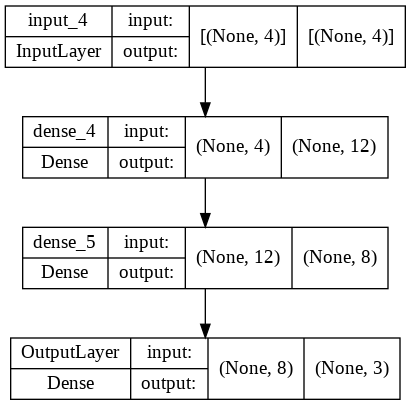

In [22]:
model = build_model()
model.summary()
utils.plot_model(model, show_shapes=True)

### | 학습

#### **모델 컴파일**

```
model.compile(loss, optimizer, metrics) 
```
* `loss` : 다중분류 문제, 'categorical_crossentropy'
* `optimizer` : 문제와 상관없음. 'adam'
* `metrics`: accuracy (정확도)


In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### **학습**

```
model.fit(x_train, y_train, epochs, batch_size)
```
* `x_train` : 넘파이 혹은 텐서 형식의 인풋 데이터
* `y_train` : 넘파이 혹은 텐서 형식의 아웃풋 데이터
* `epochs` : 학습 횟수
* `batch_size` : 배치 사이즈 ((업데이트 한번에 사용될 샘플 개수)

In [24]:
model.fit(x_train, y_train, epochs=200, batch_size=8)

Epoch 1/200
14/14 [==============================] - 0s 3ms/step - loss: 1.1313 - accuracy: 0.3333
Epoch 2/200
14/14 [==============================] - 0s 3ms/step - loss: 1.0896 - accuracy: 0.3333
Epoch 3/200
14/14 [==============================] - 0s 3ms/step - loss: 1.0574 - accuracy: 0.3333
Epoch 4/200
14/14 [==============================] - 0s 3ms/step - loss: 1.0334 - accuracy: 0.3333
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 1.0095 - accuracy: 0.3429
Epoch 6/200
14/14 [==============================] - 0s 3ms/step - loss: 0.9857 - accuracy: 0.3619
Epoch 7/200
14/14 [==============================] - 0s 3ms/step - loss: 0.9585 - accuracy: 0.4381
Epoch 8/200
14/14 [==============================] - 0s 3ms/step - loss: 0.9297 - accuracy: 0.5333
Epoch 9/200
14/14 [==============================] - 0s 4ms/step - loss: 0.8998 - accuracy: 0.6000
Epoch 10/200
14/14 [==============================] - 0s 3ms/step - loss: 0.8662 - accuracy: 0.7714
Epoch 11/

### | 검증 및 예측


#### **검증**

```
model.evaluate(x_test, y_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

In [25]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 7ms/step - loss: 0.0612 - accuracy: 0.9778


[0.06121101230382919, 0.9777777791023254]

#### **예측**

```
model.predict(x_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

* 예측 시각화

## 과제
---

### | 과제1. 이진분류 문제 정리

* 예측값의 범위 :
* 예측값의 shape :
* 아웃풋 레이어의 노드 개수 : 
* 아웃풋 레이어의 activation :
* 손실함수 (loss) : 
* 평가함수 (metrics) : 

### | 과제2. 한 셀에 코드 정리하기

* 추가 연습
  * 모델의 깊이(depth)를 늘려가며 학습해 보세요.
  * 모델의 너비(width)를 늘려가며 학습해 보세요.

### | 과제 3. MNIST 숫자 데이터 분류

```
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
```

* 데이터 시각화

### | 모델


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0105-03.PNG?raw=true width=500>
</p>


#### **모델 생성**

#### **모델 시각화**

* `model.summary()`
* `utils.plot_model()`

### | 학습

#### **모델 컴파일**

```
model.compile(loss, optimizer, metrics) 
```
* `loss` : 
* `optimizer` : 
* `metrics`: 


#### **학습**

```
model.fit(x_train, y_train, epochs, batch_size)
```
* `x_train` : 넘파이 혹은 텐서 형식의 인풋 데이터
* `y_train` : 넘파이 혹은 텐서 형식의 아웃풋 데이터
* `epochs` : 학습 횟수
* `batch_size` : 배치 사이즈 ((업데이트 한번에 사용될 샘플 개수)

### | 검증 및 예측


#### **검증**

```
model.evaluate(x_test, y_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

#### **예측**

```
model.predict(x_test)
```
* `x_test` : 넘파이 혹은 텐서 형식의 인풋 테스트 데이터
* `y_test` : 넘파이 혹은 텐서 형식의 아웃풋 테스트 데이터

* 예측 시각화

* 모델 활용